In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())
latest = latest_date[0]
#print(latest)

# Calculate the date 1 year ago from the last data point in the database
latest = dt.datetime.strptime(latest, '%Y-%m-%d')
latest = latest.date()
year_ago = latest - relativedelta(days=365)
#print(year_ago)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(results)
precip_df = precip_df.dropna(how='any')
precip_df = precip_df.set_index("date")

# Sort the dataframe by date
precip_df.sort_values(by='date', ascending=True)



,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


In [12]:
# TEST AND REMOVE
#prcp_list = []
#for result in results:
    #prcp_dict = {}
    #prcp_dict["date"] = result[0]
    #prcp_dict["prcp"] = result[1]
    #prcp_list.append(prcp_dict)
#print(prcp_list)

[{'date': '2016-08-23', 'prcp': 0.0}, {'date': '2016-08-24', 'prcp': 0.08}, {'date': '2016-08-25', 'prcp': 0.08}, {'date': '2016-08-26', 'prcp': 0.0}, {'date': '2016-08-27', 'prcp': 0.0}, {'date': '2016-08-28', 'prcp': 0.01}, {'date': '2016-08-29', 'prcp': 0.0}, {'date': '2016-08-30', 'prcp': 0.0}, {'date': '2016-08-31', 'prcp': 0.13}, {'date': '2016-09-01', 'prcp': 0.0}, {'date': '2016-09-02', 'prcp': 0.0}, {'date': '2016-09-03', 'prcp': 0.0}, {'date': '2016-09-04', 'prcp': 0.03}, {'date': '2016-09-05', 'prcp': None}, {'date': '2016-09-06', 'prcp': None}, {'date': '2016-09-07', 'prcp': 0.05}, {'date': '2016-09-08', 'prcp': 0.0}, {'date': '2016-09-09', 'prcp': 0.03}, {'date': '2016-09-10', 'prcp': 0.0}, {'date': '2016-09-11', 'prcp': 0.05}, {'date': '2016-09-12', 'prcp': 0.0}, {'date': '2016-09-13', 'prcp': 0.02}, {'date': '2016-09-14', 'prcp': 1.32}, {'date': '2016-09-15', 'prcp': 0.42}, {'date': '2016-09-16', 'prcp': 0.06}, {'date': '2016-09-17', 'prcp': 0.05}, {'date': '2016-09-18',

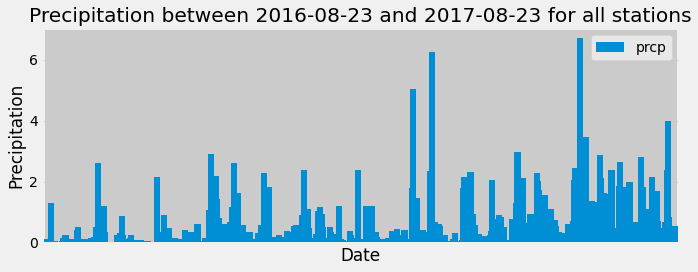

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(kind="bar", figsize=(10,4), width=20)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title(f"Precipitation between {year_ago} and {latest} for all stations")
plt.tight_layout()
plt.savefig("Chart Precipitation 12 months all stations")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {stations_count} stations in this dataset.")

There are 9 stations in this dataset.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active = active_stations[0][0]
print(f"The most active station is station {most_active}.")

The most active station is station USC00519281.


In [18]:
temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station==most_active).all()

print(f"The lowest temperature recorded is {temp_data[0][0]} degrees.")
print(f"The highest temperature recorded is {temp_data[0][1]} degrees.")
print(f"The average temperature recorded is {temp_data[0][2]} degrees.")

The lowest temperature recorded is 54.0 degrees.
The highest temperature recorded is 85.0 degrees.
The average temperature recorded is 71.66378066378067 degrees.


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

max_obsv_station = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==most_active).filter(Measurement.date>year_ago).order_by(Measurement.tobs.desc()).all()
df = pd.DataFrame(max_obsv_station)
df.head()
df.set_index('date')

,tobs
date,
2017-08-06,83.0
2017-07-23,82.0
2017-07-29,82.0
2017-08-05,82.0
2017-03-11,81.0
...,...
2017-02-03,60.0
2017-04-30,60.0
2017-02-02,59.0


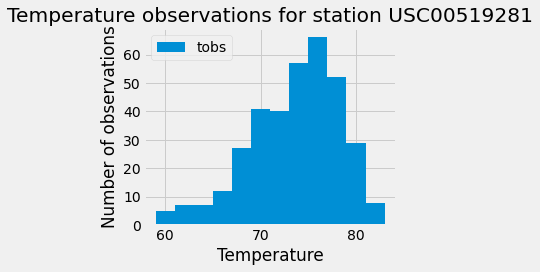

In [20]:
df.plot.hist('tobs', bins=12)
plt.xlabel("Temperature")
plt.ylabel("Number of observations")
plt.title(f"Temperature observations for station {most_active}")
plt.tight_layout()
plt.savefig("Histogram temperature observations most active station")
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (strin): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
end_date_trip = latest
start_date_trip = latest - relativedelta(days=14)
print(end_date_trip)
print(start_date_trip)

def calc_temps(start_date_trip, end_date_trip):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date_trip).filter(Measurement.date <= end_date_trip).all()

# function usage example
temp_trip = calc_temps(start_date_trip, end_date_trip)
print(temp_trip)

df = pd.DataFrame(temp_trip, columns=["Min", "Max", "Avg"])

2017-08-23
2017-08-09
[(70.0, 78.64406779661017, 85.0)]


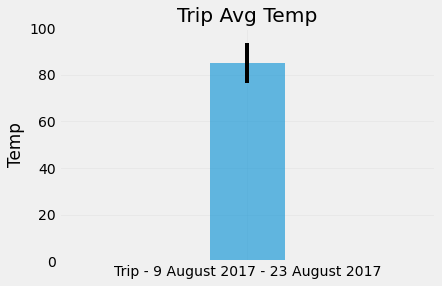

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_value = {start_date_trip, end_date_trip}
y_value = df.iloc[0]["Avg"]
yerr =  df.iloc[0]["Max"]-df.iloc[0]["Min"]
plt.bar('Trip - 9 August 2017 - 23 August 2017', y_value, yerr=yerr, align="center", alpha=0.6)
plt.xlim(-2, 2)
plt.ylim(0,100)
plt.title("Trip Avg Temp")
plt.ylabel("Temp")
plt.grid(alpha=0.2)

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = ([Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation])
rainfall = session.query(*results).filter(Station.station == Measurement.station).filter(Measurement.date >= start_date_trip).filter(Measurement.date <= end_date_trip).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all() 
df_rainfall = pd.DataFrame(rainfall, columns=["Station", "Name", "Total Precipitation", "Latitude", "Longitude", "Elevation"])
df_rainfall

,Station,Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.15,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.51,21.45167,-157.84889,32.9
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.34,21.33556,-157.71139,19.5
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.04,21.52130,-157.83740,7.0
4,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.27160,-157.81680,3.0


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = dt.datetime.strftime(start_date_trip, "%m-%d")
end = dt.datetime.strftime(end_date_trip, "%m-%d")

# convert to datatime object
start = dt.datetime.strptime(start, "%m-%d")
end = dt.datetime.strptime(end, "%m-%d")

# Use the start and end date to create a range of dates
date_range = (start + dt.timedelta(days=x) for x in range(0, ((end-start).days) + 1))

# Stip off the year and save a list of %m-%d strings
list_strings = []
for x in date_range:
    string_date = x.strftime("%m-%d")
    list_strings.append(string_date)
    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for x in list_strings:
    normals.append(daily_normals(x))

min_temp_list = []
avg_temp_list = []
max_temp_list = []
print(normals)

for y in normals:
    for min_temp, avg_temp, max_temp in y:
        min_temp_list.append(min_temp)
        avg_temp_list.append(avg_temp)
        max_temp_list.append(max_temp)

[[(69.0, 75.98039215686275, 81.0)], [(65.0, 76.42, 83.0)], [(67.0, 75.98113207547169, 82.0)], [(67.0, 76.52727272727273, 83.0)], [(71.0, 76.98245614035088, 84.0)], [(71.0, 76.77777777777777, 82.0)], [(69.0, 76.47169811320755, 83.0)], [(69.0, 76.08, 83.0)], [(69.0, 76.125, 83.0)], [(70.0, 76.92307692307692, 84.0)], [(69.0, 75.94642857142857, 85.0)], [(68.0, 76.45283018867924, 82.0)], [(67.0, 76.4, 83.0)], [(69.0, 76.47169811320755, 84.0)], [(67.0, 76.6923076923077, 87.0)]]


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame({"trip_dates": list_strings, "tmin": min_temp_list, "tavg":avg_temp_list, "tmax":max_temp_list})
df_normals.set_index("trip_dates", inplace=True)

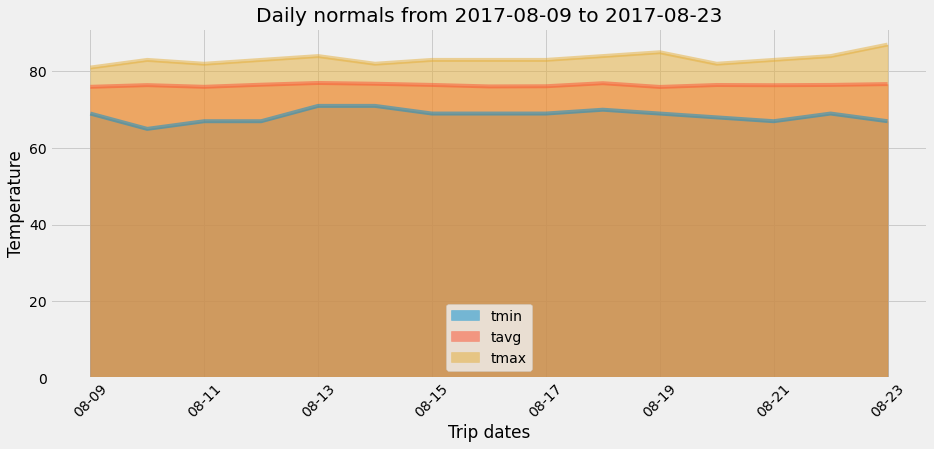

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
df_normals.plot.area(stacked=False, figsize=(14,6))
plt.title(f"Daily normals from {start_date_trip} to {end_date_trip}")
plt.xlabel("Trip dates")
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.legend(loc="lower center")
plt.show()
plt.savefig("Daily_normals_chart")